In [1]:
import torch
import mne
import pickle
import numpy as np

# Split the dataset for validation

In [ ]:
from Data_processing import get_data, get_dataloaders
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

batch_size = 32

epochs, labels = get_data(file_path='data/resampled_epochs_subj_0_corrected.pkl')
train_loader, test_loader = get_dataloaders(epochs, labels, batch_size, return_val_set=False)

# Split the train_loader 

# optuna_dataset 
def get_valset(train_loader, validation_split):
    trainset_size = len(train_loader.dataset)
    subset_size = validation_split
    subset_indices = np.random.choice(trainset_size, size=int(subset_size * trainset_size), replace=False)
    val_set = Subset(train_loader.dataset,subset_indices)
    return val_set

def get_optuna_dataloader(optuna_dataset, batch_size,validation_split=0.2):
    # Extract indices from the train_loader dataset
    indices = list(range(len(optuna_dataset)))
    # Split indices into training and validation sets
    train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)
    # Create Subset datasets and DataLoaders for training and validation
    train_set = Subset(optuna_dataset, train_indices)
    val_set = Subset(optuna_dataset, val_indices)
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available())
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=1,
        shuffle=False,
        pin_memory=torch.cuda.is_available())
    return train_loader, val_loader

optuna_dataset = get_valset(train_loader)
o_train_loader, o_val_loader = get_optuna_dataloader(optuna_dataset, batch_size,validation_split=0.2)
 


# Data eploration

In [2]:
from Data_processing import load_data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from mne.decoding import Scaler
from mne import create_info
epochs = load_data(file_path='data/resampled_epochs_subj_1.pkl') 
tmin = 0
tmax = 0.746875
epochs.crop(tmin=tmin, tmax=tmax)
# Scale the data
info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg') 
scaler = Scaler(info=info, scalings='median', with_mean=True, with_std=True)
scaler.fit(epochs.get_data())
X = scaler.transform(epochs.get_data())
print(X.shape)

(2990, 128, 192)


# Add noise
bad channels:
* 53 --> red
* 63 --> red
* 112 --> green
* 56 --> purple (subject 1)

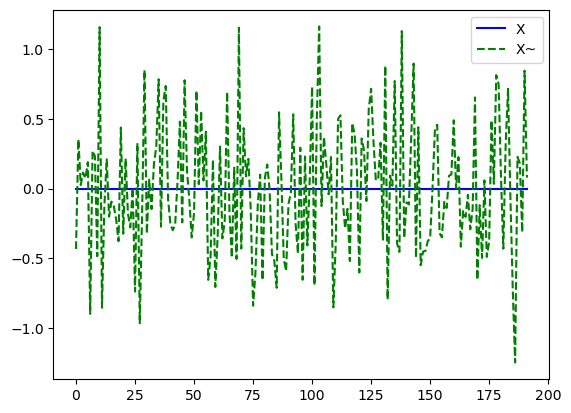

In [26]:
gaussian_noise = np.random.normal(0, 0.5, X.shape)
X_noise = X + gaussian_noise

plt.plot(X[40,63,:], label='X', color='blue')
plt.plot(X_noise[0,63,:], label='X~', color='green', linestyle='dashed')
plt.legend()
plt.show()

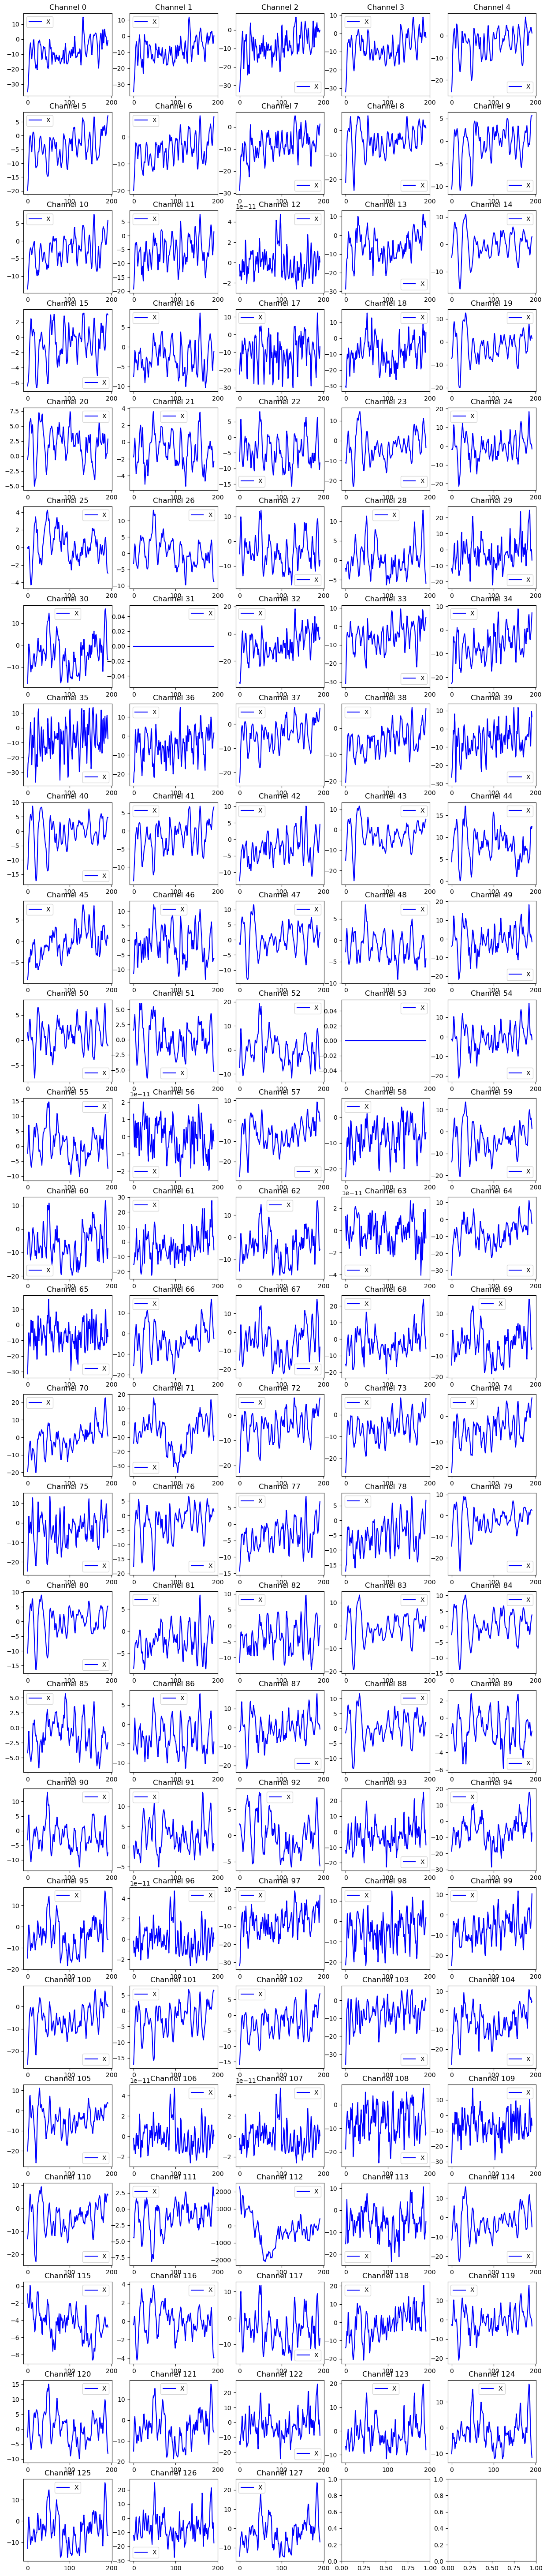

In [ ]:
import matplotlib.pyplot as plt

# Generate Gaussian noise
gaussian_noise = np.random.normal(0, 0.5, X.shape)
X_noise = X + gaussian_noise

# Randomly select 25 channels
#channels = np.random.choice(range(X.shape[1]), size=25, replace=False)
channels = np.arange(128)

# Create a 5x5 subplot
fig, axs = plt.subplots(26, 5, figsize=(15, 15*5))

for i, ax in enumerate(axs.flatten()):
    if i < channels.shape[0]:
        channel = channels[i]
        ax.plot(X[1133, channel, :], label='X', color='blue')
        #ax.plot(X_noise[353, channel, :], label='X~', color='green', linestyle='dashed')
        ax.legend()
        ax.set_title(f'Channel {channel}')

#plt.tight_layout()
plt.show()

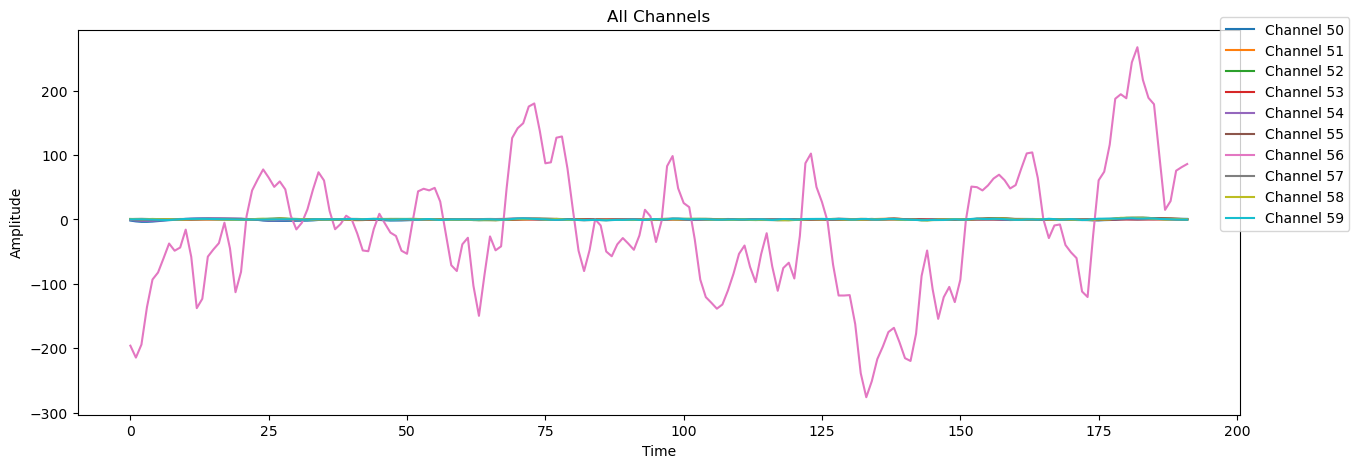

In [23]:
# All channels for one epoch
epoch_number = 2813
# Create a plot
plt.figure(figsize=(15, 5))

# Loop over all channels
#for channel in range(X.shape[1]):
for channel in range(50,60):
    plt.plot(X[epoch_number, channel, :], label=f'Channel {channel}')

plt.title('All Channels')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.show()

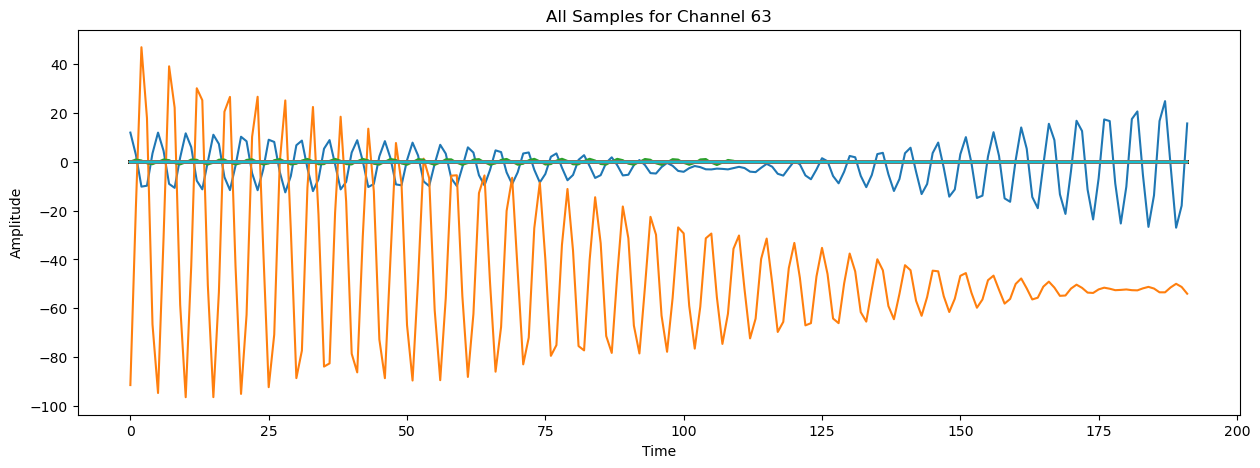

In [8]:
# All epochs for one channel
channel_number = 63
# Create a plot
plt.figure(figsize=(15, 5))

# Loop over all samples
for sample in range(X.shape[0]):
    plt.plot(X[sample, channel_number, :], label=f'Sample {sample}')

plt.title('All Samples for Channel 63')
plt.xlabel('Time')
plt.ylabel('Amplitude')
#plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.show()

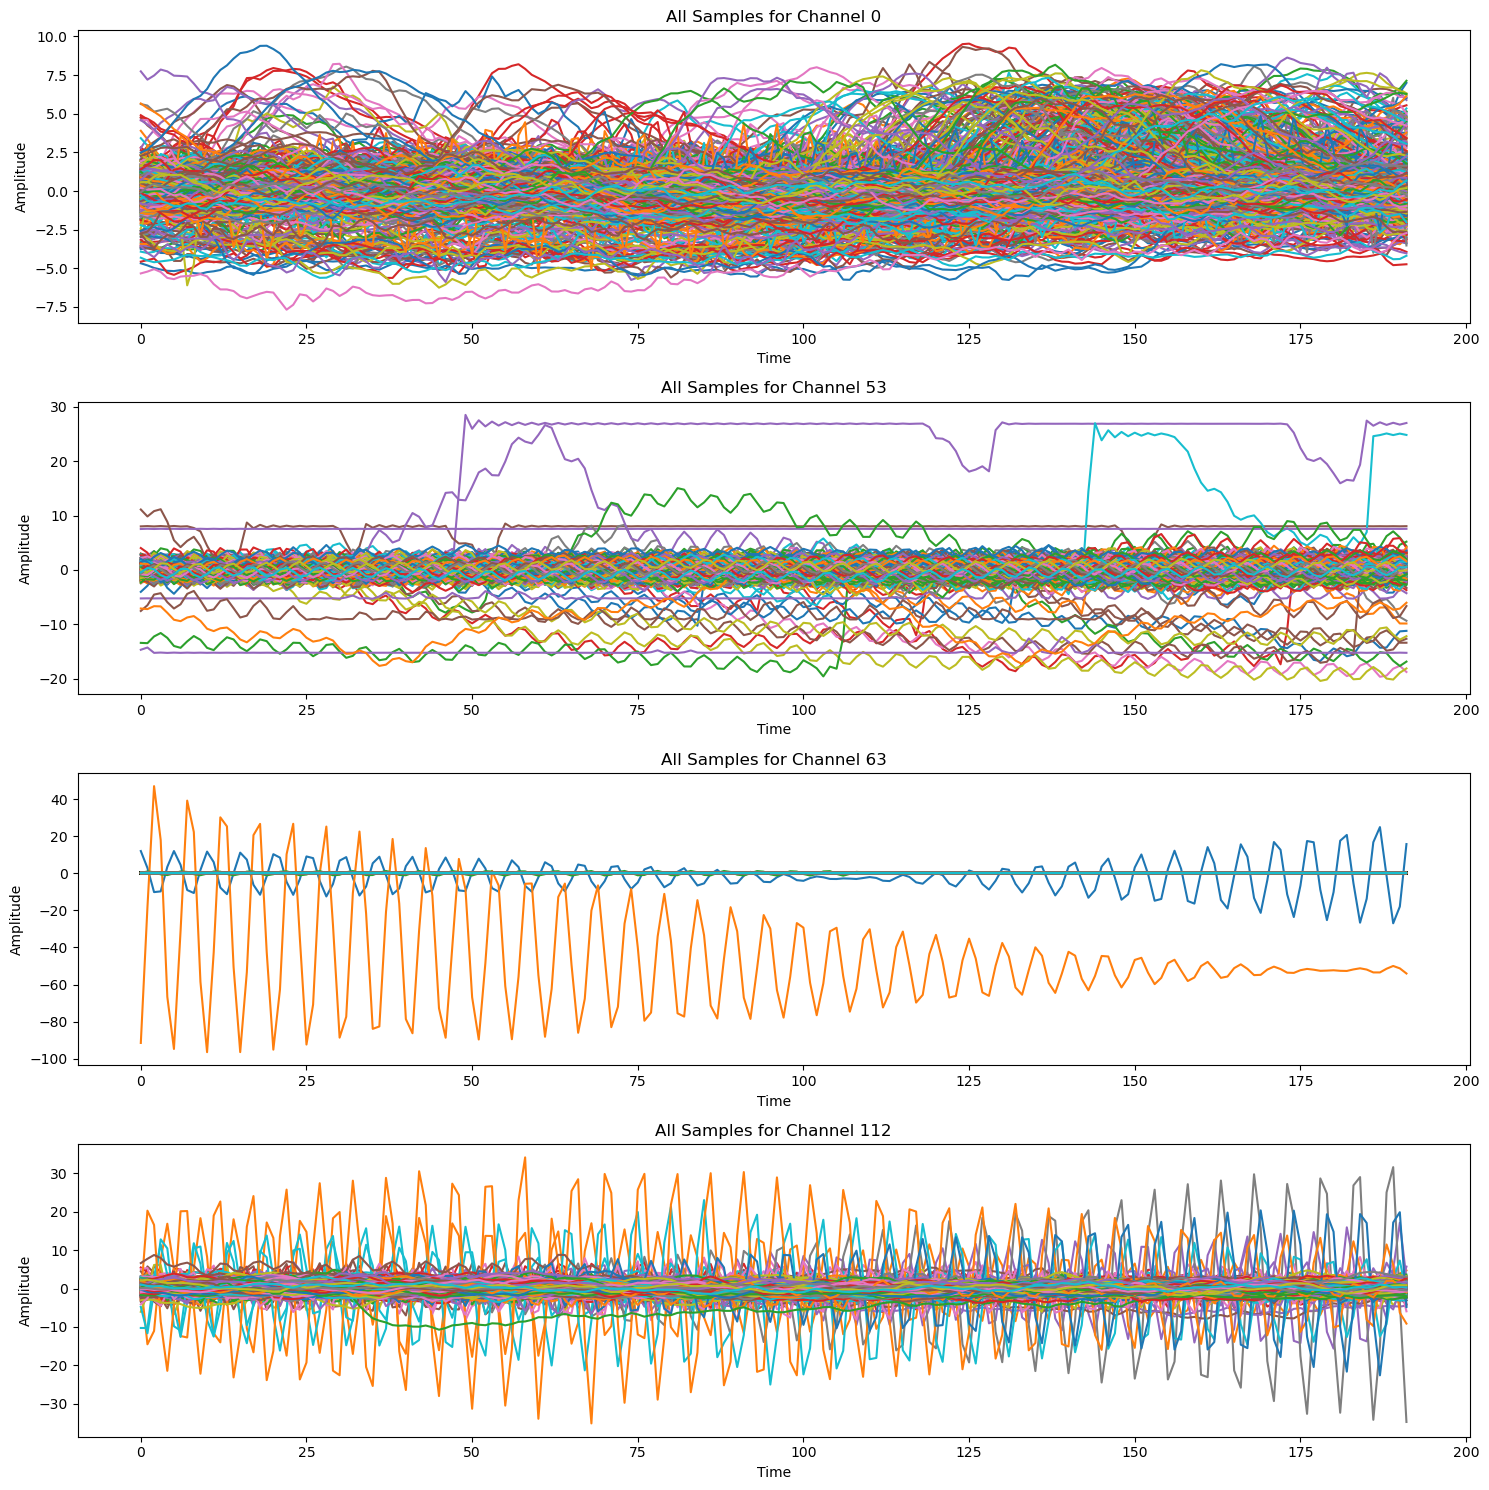

In [9]:
# All epochs for the problematic channels

# Define the channels
channels = [0,53, 63, 112]

# Create a subplot with 4 panels
fig, axs = plt.subplots(4, 1, figsize=(15, 15))

for i, ax in enumerate(axs):
    channel = channels[i]
    for sample in range(X.shape[0]):
        ax.plot(X[sample, channel, :], label=f'Sample {sample}')
    ax.set_title(f'All Samples for Channel {channel}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    #ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()
plt.show()

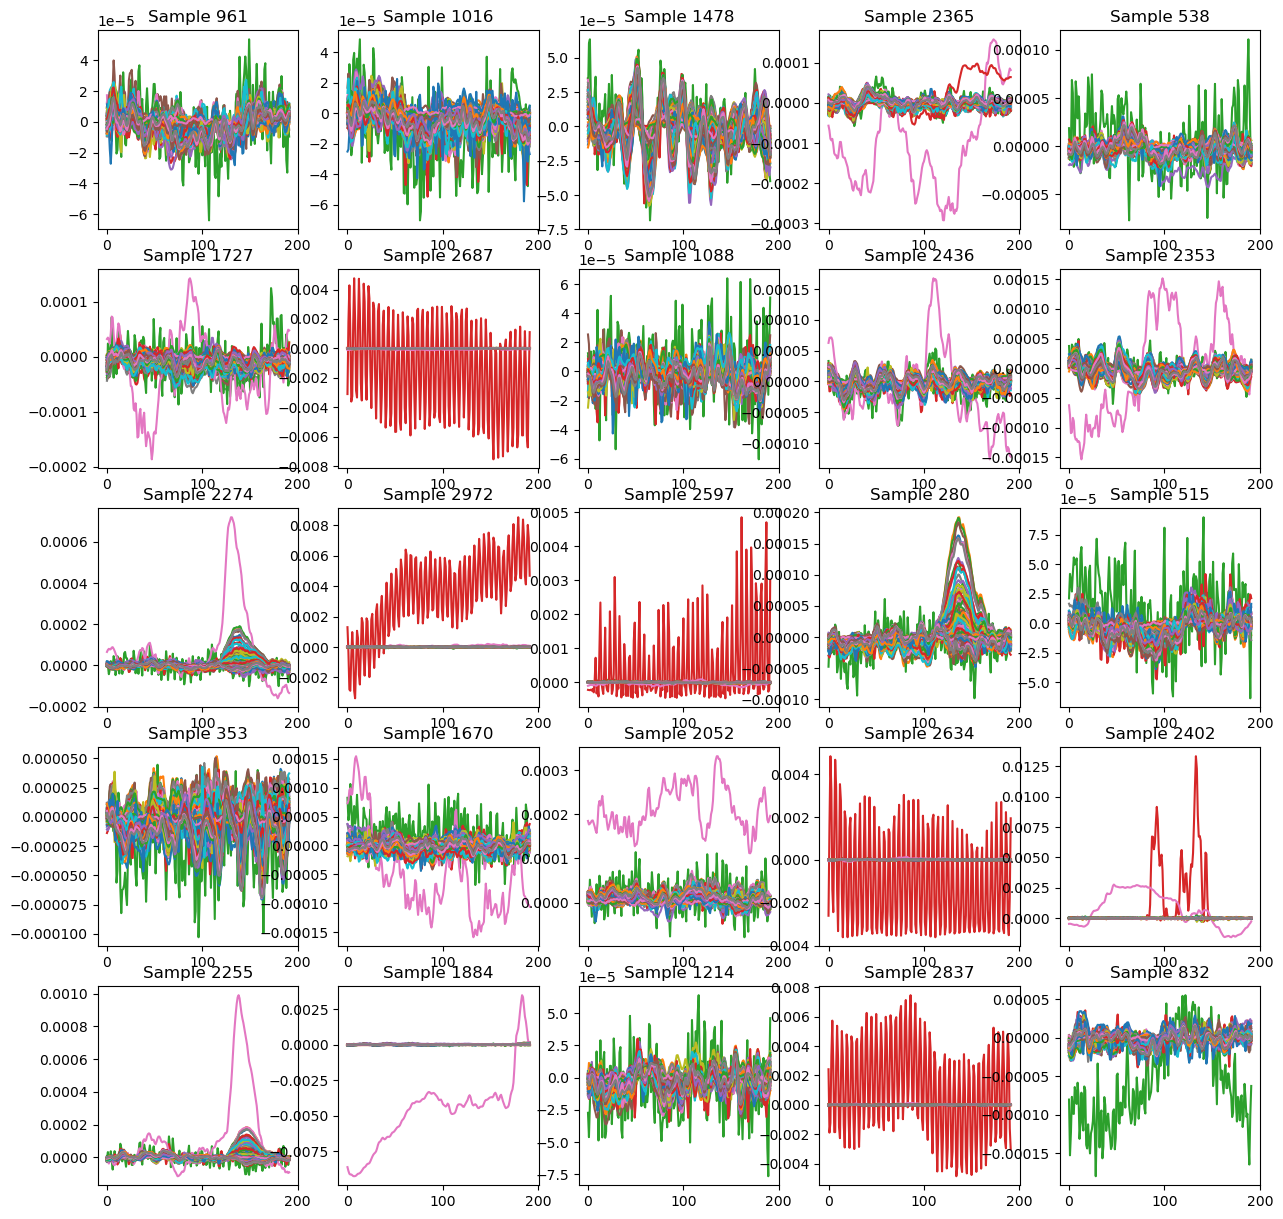

In [24]:
# All channels for 25 random chosen samples

# X = epochs.get_data() # for non normalized data
# Randomly select 25 samples
samples = np.random.choice(range(X.shape[0]), size=25, replace=False)

# Create a 5x5 subplot
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    sample = samples[i]
    for channel in range(X.shape[1]):
        ax.plot(X[sample, channel, :], label=f'Channel {channel}')
    #ax.legend()
    ax.set_title(f'Sample {sample}')

#plt.tight_layout()
plt.show()

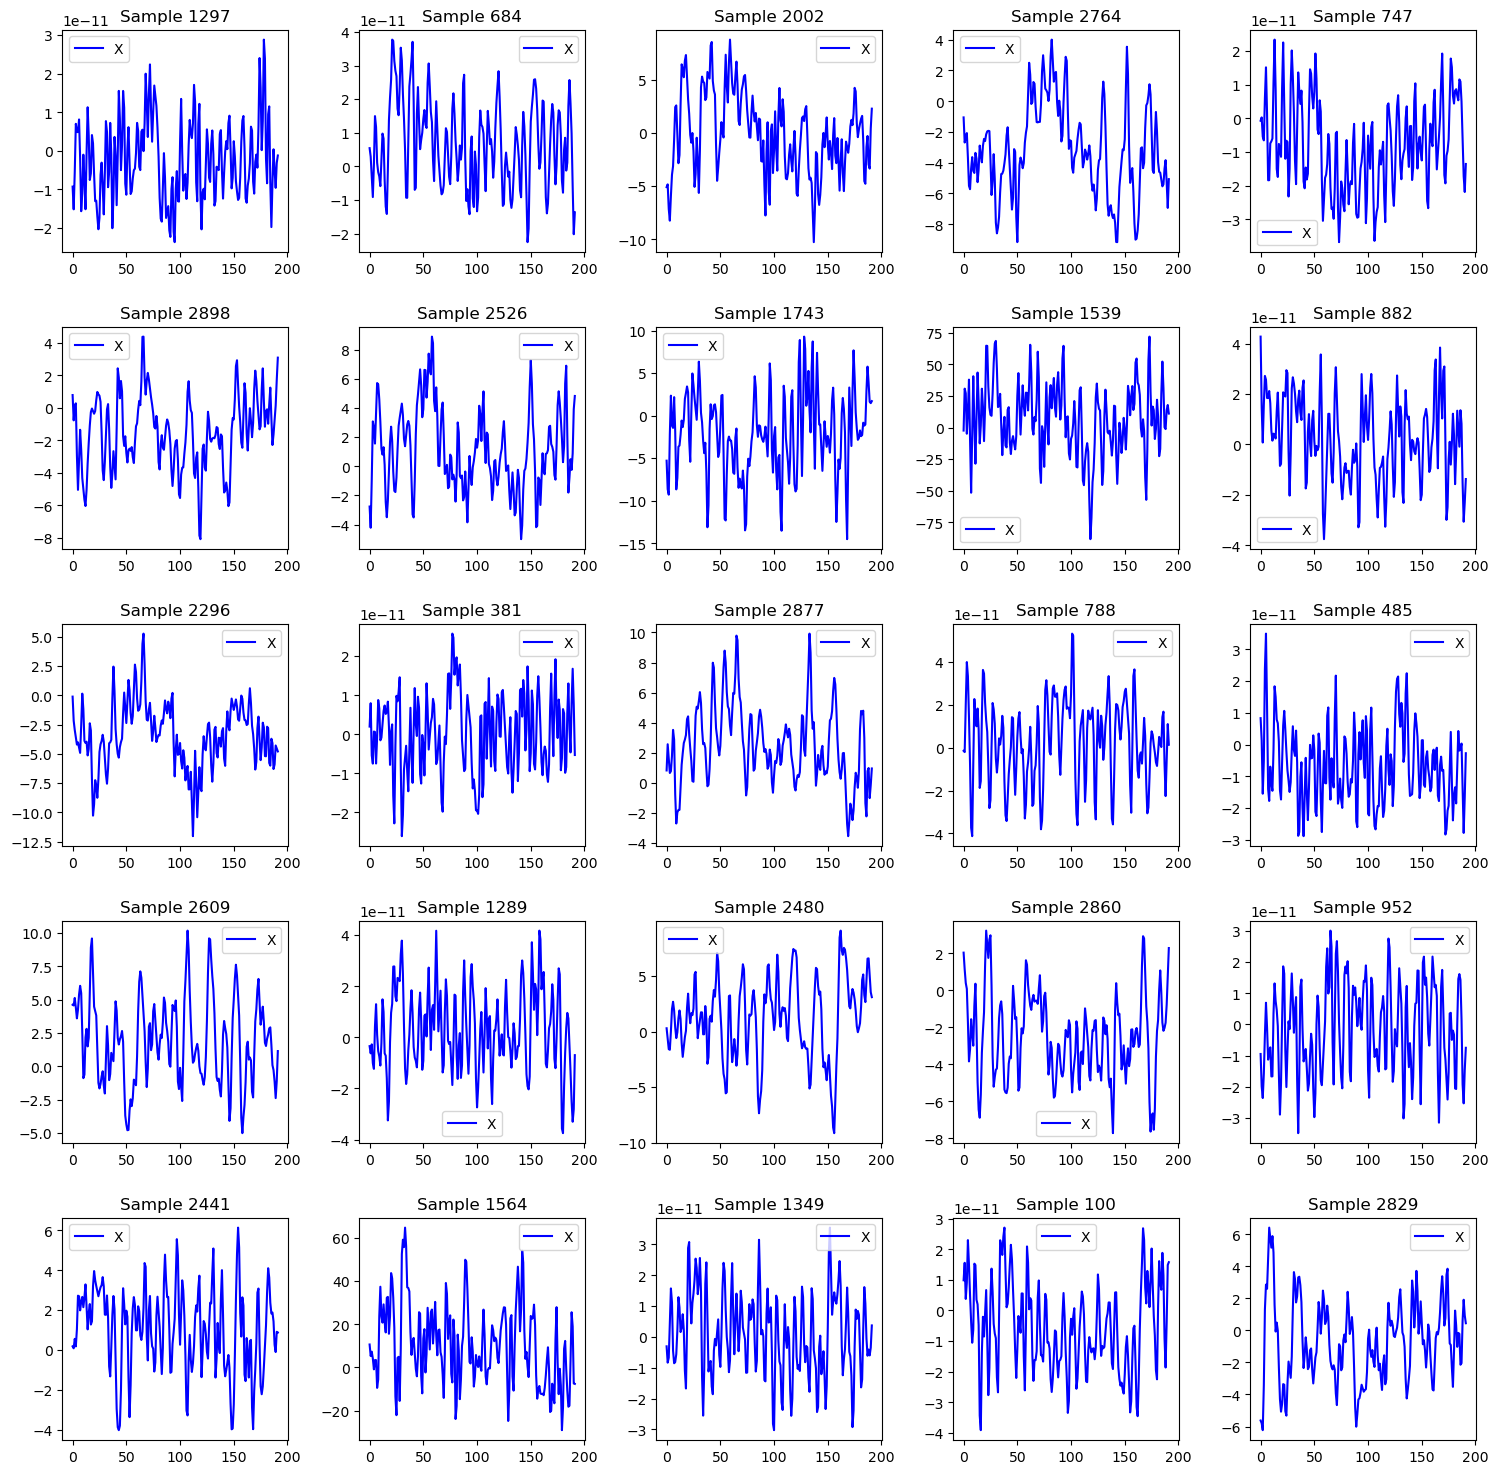

In [63]:
# Randomly select 25 samples
samples = np.random.choice(range(X.shape[0]), size=25, replace=False)

# Create a 5x5 subplot
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    sample = samples[i]
    ax.plot(X[sample, 106, :], label='X', color='blue')
    #ax.plot(X_noise[sample, 63, :], label='X~', color='green', linestyle='dashed')
    ax.legend()
    ax.set_title(f'Sample {sample}')

plt.tight_layout()
plt.show()

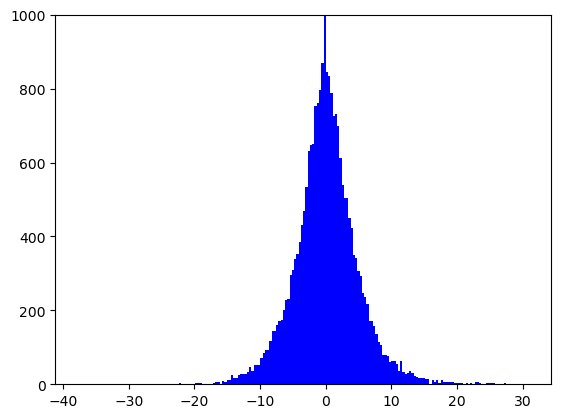

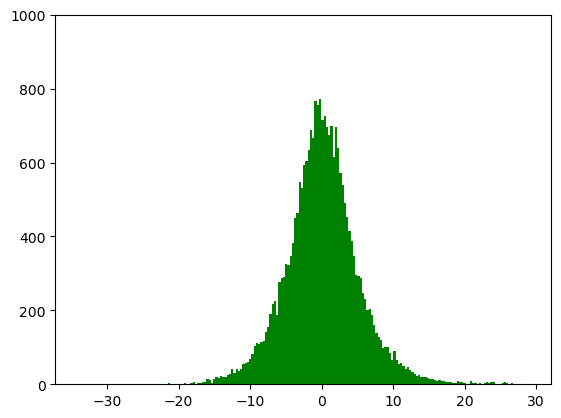

In [49]:
# Plot the hidtogram of the one EEG
plt.hist(X[0,:,:].flatten(), bins=200, color='blue')
# Adust the y-axis to see the histogram better
plt.ylim(0, 1000)
plt.show()
plt.hist(X_noise[0,:,:].flatten(), bins=200, color='green')
plt.ylim(0, 1000)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X[0,0,:], label='X')
plt.plot(samples[0,0,:], label='Samples')
plt.legend()

plt.show()

In [5]:
from Data_processing import make_labels_grid_tensor
class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset

    Parameters
    ----------
    epochs_data : 3d array, shape (n_epochs, n_channels, n_times)
        The epochs data.
    epochs_labels : array of int, shape (n_epochs,)
        The epochs labels.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X)
        return X, y

class MneScalerTransform(transforms.Transform):
    """Applies MNE Scaler transformation"""
    def __init__(self, info):
        self.scaler = Scaler(info=info, scalings=None, with_mean=True, with_std=True)

    def __call__(self, epochs):
        self.scaler.fit(epochs)
        return self.scaler.transform(epochs)
info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg')
transform = transforms.Compose([MneScalerTransform(info)])
#transform = transforms.Compose([Scaler.fit_transform,transforms.ToTensor()])
labels = epochs.events[:, 2] 
labels = make_labels_grid_tensor(labels)
# Apply the transform to the epochs data 
epochs_data = epochs.get_data()
print(epochs_data.shape)
#epochs_data = transform(epochs_data)
print(epochs_data.shape)
dataset = EpochsDataset(epochs_data,labels,transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
next(iter(dataloader))

AttributeError: module 'torchvision.transforms' has no attribute 'Transform'

In [9]:
from Data_processing import make_labels_grid_tensor
def get_dataloaders(epochs,batchsize):
    dataset_cls = EpochsDataset
    
    info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg')
    transform = transforms.Compose([MneScalerTransform(info), transforms.ToTensor()])
    labels = epochs.events[:, 2] 
    labels = make_labels_grid_tensor(labels)
    epochs_data = epochs.get_data()
    dataset = dataset_cls(epochs_data, labels, transform=transform)
    return DataLoader(dataset, batch_size=batchsize, shuffle=True)

data_loader = get_dataloaders(epochs, 32)

next(iter(data_loader))

ValueError: info had 128 data channels but X has 128 channels

In [17]:
print(len(epochs.ch_names))  # Number of channels in epochs
print(len(info.ch_names))  # Number of channels in info


128
128


In [18]:
info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg')
transform = transforms.Compose([MneScalerTransform(info)])
labels = epochs.events[:, 2] 
labels = make_labels_grid_tensor(labels)

# Apply the transform to the epochs data 
epochs_data = epochs.get_data()
print(epochs_data.shape)
epochs_data = transform(epochs_data)
print(epochs_data.shape)

# Create the dataset without applying the transform again
dataset = EpochsDataset(epochs_data, labels, transform=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
next(iter(dataloader))


(2989, 128, 269)
(2989, 128, 269)


[tensor([[[ 7.7307e+00,  1.2656e+01,  1.6777e+01,  ...,  2.0652e+00,
            4.0187e+00,  7.2489e+00],
          [ 8.9844e+00,  1.3689e+01,  1.6780e+01,  ..., -2.2361e+00,
           -4.5096e-01,  3.6542e+00],
          [ 1.4181e+01,  1.9932e+01,  2.2319e+01,  ..., -5.3345e-01,
            1.0749e+00,  4.6914e+00],
          ...,
          [-4.2169e+00, -4.0307e+00,  4.0289e+00,  ..., -5.0731e+00,
           -9.6629e+00, -1.0140e+01],
          [-3.9547e+00, -2.2629e-02,  9.6689e+00,  ...,  4.3047e+00,
           -3.9229e+00, -6.1128e-01],
          [-5.3050e+00, -3.1690e+00,  9.3683e+00,  ..., -7.8219e+00,
           -1.5239e+01, -7.8762e+00]],
 
         [[-4.9989e+00, -3.5075e+00,  3.6414e-01,  ...,  1.6072e+01,
            1.1269e+01,  5.0987e+00],
          [ 1.6174e+00,  1.9542e+00,  3.9487e+00,  ...,  1.4712e+01,
            1.0675e+01,  6.5061e+00],
          [ 4.2601e+00,  4.9508e+00,  6.5137e+00,  ...,  1.5639e+01,
            1.3970e+01,  9.8816e+00],
          ...,
    

In [19]:
class EpochsDataset(Dataset):
    def __init__(self, epochs_data, epochs_labels, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X)
        return X, y

info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg')
transform = transforms.Compose([MneScalerTransform(info)])
labels = epochs.events[:, 2] 
labels = make_labels_grid_tensor(labels)

# Do not apply the transform here
epochs_data = epochs.get_data()
print(epochs_data.shape)

# Apply the transform in the dataset
dataset = EpochsDataset(epochs_data, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
next(iter(dataloader))


(2989, 128, 269)


ValueError: info had 128 data channels but X has 128 channels

### Cut the data



In [17]:
#Make a vlidation set
from torch.utils.data import Dataset
from torchvision import transforms

from mne.decoding import Scaler
from mne import create_info

from sklearn.model_selection import train_test_split

# Code from https://github.com/mne-tools/mne-torch.git

import numpy as np
import matplotlib.pyplot as plt

def get_data(file_path='data/resampled_epochs_subj_0.pkl'):
    '''
    Args:
        file_path: str, The path to the .pkl file
    Returns:
        epochs: mne.EpochsArray, The epochs object
    '''
    # Load data
    epochs = load_data(file_path)
    # Crop the data to keep it only when the visual stimulus was on
    tmin = 0
    tmax = 0.746875
    epochs.crop(tmin=tmin, tmax=tmax)

    return epochs

class MneScalerTransform:
    """Applies MNE Scaler transformation"""
    def __init__(self, info):
        self.scaler = Scaler(info=info, scalings=None, with_mean=True, with_std=True)

    def __call__(self, epochs):
        self.scaler.fit(epochs)
        return self.scaler.transform(epochs)

class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset

    Parameters
    ----------
    epochs_data : 3d array, shape (n_epochs, n_channels, n_times)
        The epochs data.
    epochs_labels : array of int, shape (n_epochs,)
        The epochs labels.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X)
        return X, y

def get_dataloaders(epochs, batch_size):
    ''' 
    Args:
        epochs: mne.EpochsArray, EEG data in mne format
        batch_size: int,
    Returns:
        train_loader: torch.utils.data.DataLoader, 
        val_loader: torch.utils.data.DataLoader, 
        test_loader: torch.utils.data.DataLoader, 
    '''
    dataset_cls = EpochsDataset

    # Create the transform
    info = create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types='eeg') 
    transform = transforms.Compose([MneScalerTransform(info), transforms.ToTensor()])
    # Get the labels and turn them into a grid tensor
    labels = epochs.events[:, 2] 
    labels = make_labels_grid_tensor(labels)

    # Extract the data from the epochs object
    epochs = epochs.get_data()



    # Split the data into train, validation and test sets
    X_temp, epochs_test, y_temp, labels_test = train_test_split(epochs, labels, test_size=0.3, random_state=42)
    print(X_temp)
    epochs_train, epochs_val, labels_train, labels_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
    print(f'Dataset is split')

    # Make the datasets
    train_set = dataset_cls(epochs_data=epochs_train, epochs_labels=labels_train, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    val_set = dataset_cls(epochs_data=epochs_val, epochs_labels=labels_val, transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    test_set = dataset_cls(epochs_data=epochs_test, epochs_labels=labels_test, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    return train_loader, val_loader, test_loader


In [4]:
file_path='data/resampled_epochs_subj_0.pkl'
epochs, labels = get_data(file_path)
train_loader, val_loader, test_loader = get_dataloaders(epochs, labels, batch_size=1)
print(f'loaders are loaded')
list_test = []

for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(data.shape)
    list_test.append(1)
    print(data.shape)

print(len(list_test))

Dataset is split
loaders are loaded
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.Size([1, 1, 128, 192])
torch.S

In [5]:
inputs_train, targets_train = next(iter(train_loader))

In [6]:
print(inputs_train.shape)
print(targets_train.shape)

torch.Size([1, 1, 128, 192])
torch.Size([1, 5, 5])


# Observe the freqency domain

In [14]:
epochs = load_data('data/resampled_epochs_subj_0.pkl')
# Crop the data to keep it only when the visual stimulus was on
tmin = 0
tmax = 0.746875
epochs.crop(tmin=tmin, tmax=tmax)
labels = epochs.events[:, 2] 

In [15]:
import matplotlib.pyplot as plt
import mne
import numpy as np

# Assuming 'epochs' is your mne.Epochs object
psds, freqs = mne.time_frequency.psd_multitaper(epochs, fmin=1., fmax=70., bandwidth=1.)

# Convert power to dB scale
psds_db = 10 * np.log10(psds)

# Average across epochs
psds_db_mean = psds_db.mean(0)

# Plot the result
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds_db_mean.T)
plt.title('PSD (dB) of EEG data (averaged across epochs)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()


AttributeError: module 'mne.time_frequency' has no attribute 'psd_multitaper'

    Using multitaper spectrum estimation with 7 DPSS windows
psds shape: (2989, 128, 96), freqs shape: (96,)


C:\Users\maudd\AppData\Local\Temp\ipykernel_4744\152861099.py:11: RuntimeWarning: divide by zero encountered in log10
  psds_db = 10 * np.log10(psds)


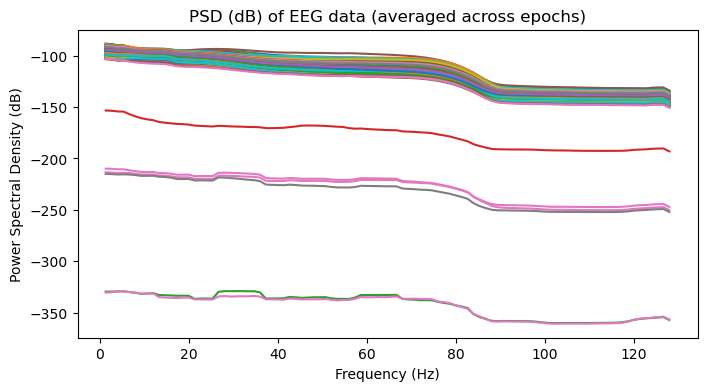

In [21]:


# Assuming 'epochs' is your mne.Epochs object
# Get the data and sampling frequency from the epochs
data = epochs.get_data()
sfreq = epochs.info['sfreq']

# Compute the PSD
psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq, fmin=1., fmax=200)
print(f'psds shape: {psds.shape}, freqs shape: {freqs.shape}')

# Convert power to dB scale
psds_db = 10 * np.log10(psds)

# Average across epochs
psds_db_mean = psds_db.mean(0)

# Plot the result
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds_db_mean.T)
plt.title('PSD (dB) of EEG data (averaged across epochs)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.show()
